# Autoencoders for image denoising

## 1. Identifying the best model on CIFAR-10

### 1.1 Initialisation and visualising images

#### 1.1.1 Initialisation

##### CIFAR-10 Dataset

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from pl_bolts.models.autoencoders import AE

from datasets import TransformedDataset

import torch.utils.data as data
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

# SSIM
from piqa import SSIM

from datasets import CatsAndDogs
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

# set the device to train on GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

input_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.8,2)),
    #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.8,2)),
    #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

data_dir = 'dataset'

# get data
train_dataset = datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True)

# split training set into training and validation
train_data, val_data = data.random_split(train_dataset, [45000, 5000])

# using custom dataclass to transform and return both clean image and transformed image
train_data = TransformedDataset(dataset = train_data, transform = train_transform, input_transform = input_transform)
val_data = TransformedDataset(dataset = val_data, transform = valid_transform, input_transform = input_transform)
test_data = TransformedDataset(dataset = test_dataset, transform = valid_transform, input_transform = input_transform)

# set batch size and define the data loaders
batch_size = 256
test_size = 3

# define data loaders
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=2)
valid_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_data, batch_size=test_size, shuffle=False, drop_last=False, num_workers=2)

Device: cuda
Files already downloaded and verified
Files already downloaded and verified


#### 1.1.2 Visualising dataset

Batch mean tensor([0.4912, 0.4797, 0.4430])
Batch std tensor([0.2505, 0.2483, 0.2562])
Min: 0.0, Max: 1.000000238418579


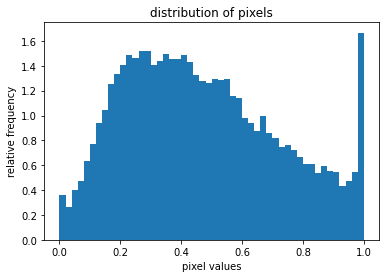

In [2]:
x_tran, y , x_in = next(iter(train_loader))
print("Batch mean", x_tran.mean(dim=[0,2,3]))
print("Batch std", x_tran.std(dim=[0,2,3]))
print(f'Min: {x_tran.min()}, Max: {x_tran.max()}')

# Convert tensor image to numpy array
img_np = np.array(x_tran)
  
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
plt.show()

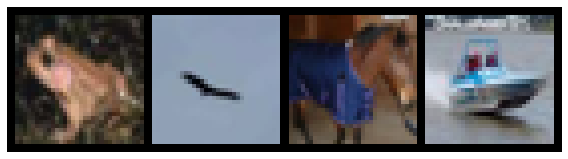

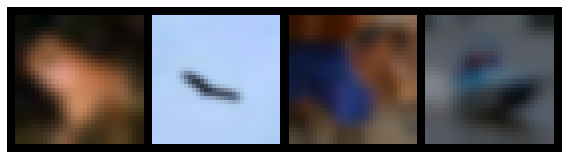

In [3]:
# function to show images
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.tight_layout()
    
# get some random training images
dataiter = iter(train_loader)
x_tran, y, x_in = dataiter.next()

# show images
n_images = 4
imshow(torchvision.utils.make_grid(x_in[:n_images], nrow= 4, normalize=True))
imshow(torchvision.utils.make_grid(x_tran[:n_images], nrow= 4, normalize=True))

### 1.2 Training models

In [ ]:
import torch.optim as optimizer
from models import UNET, small_ae, large_ae, cnn, UNET_noskip, resnet18_ae

# loss function
mse_fn = nn.MSELoss()
#ssim_fn = SSIM().to(device)

# hyper parameters
lr= 1e-3
w_decay = 1e-6
latent_dim = 512 # latent dimension

# model
#model = large_ae(3, 128, latent_dim)
#model = small_ae(3, 128, latent_dim, out_act_fun = nn.Sigmoid)
#model = AE(input_height=128, latent_dim = latent_dim, enc_type=)
#model = model.from_pretrained('cifar10-resnet18')
model = cnn()
#model = resnet18_ae(128, latent_dim=latent_dim)

optim = optimizer.Adam(model.parameters(), lr=lr, weight_decay=w_decay)
scheduler = optimizer.lr_scheduler.ExponentialLR(optim, gamma = 0.90, last_epoch=- 1, verbose=True)

model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

The training loop was used to train all models.

In [ ]:
from training import train, test
from tqdm import tqdm

num_epochs = 30
loss_dict={'train_loss':[],'val_loss':[]}

# set up wandb
config = dict (
    learning_rate = lr,
    weight_decay = w_decay,
    epochs = num_epochs,
    batch_size = batch_size,
    encoded_dim = latent_dim,
    model = model,
    dataset = 'CIFAR10'
)

wandb.init(
    project="autoencoder", 
    entity="mads_birch", 
    config = config)

for epoch in range(num_epochs):

    train_loss=train(
        model = model,
        device=device, 
        dataloader=train_loader, 
        loss_1 = mse_fn, 
        optimizer=optim)
    
    val_loss = test(
        model = model, 
        device=device, 
        dataloader=valid_loader, 
        loss_1 = mse_fn,
        plot= True)

    wandb.log({
        'training loss': train_loss,
        'test loss': val_loss})

    loss_dict['train_loss'].append(train_loss)
    loss_dict['val_loss'].append(val_loss)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

print("Finsished training")

PATH = "plot_runs/cnn_mse.pth"
torch.save(model.state_dict(), PATH)

### 1.3 Get mean MSE and standard deviation over 5 independent training runs.

The training loop below was used to obtain mean and standard deviation over 5 independent training runs for each model.

In [ ]:
from training import train, test
from tqdm import tqdm
from piqa import SSIM
from models import UNET, small_ae, large_ae, cnn, UNET_noskip

# loss function
mse_fn = nn.MSELoss()
#loss_fn = nn.BCELoss()
ssim_fn = SSIM().to(device)

# hyper parameters
lr= 1e-3
w_decay = 1e-5
latent_dim = 512

#model = large_ae(3, 128, latent_dim, out_act_fun = nn.Tanh)
model = small_ae(3, 128, latent_dim, out_act_fun = nn.Sigmoid)
#model = UNET()
#model = large_cnn_ae(out_act_fun = nn.Tanh)
#model = AE(input_height=32, latent_dim = 512).from_pretrained('cifar10-resnet18').to(device)


num_epochs = 30

TRAIN_LOSS, VAL_LOSS = np.zeros((num_epochs,5)), np.zeros((num_epochs,5))

seeds = [1,2,3,4,5]

for s in seeds:
# set up wandb
    # set seeds
    torch.manual_seed(s)
    
    import torch.optim as optimizer
    
    model = UNET_noskip(features=[16, 32, 64, 128]).to(device)

    optim = optimizer.Adam(model.parameters(), lr=lr, weight_decay=w_decay)
    scheduler = optimizer.lr_scheduler.ExponentialLR(optim, gamma = 0.90, last_epoch=- 1, verbose=False)
    
    train_loss_run, val_loss_run= [], []
    for epoch in range(num_epochs):
        train_loss=train(
            model = model,
            device=device, 
            dataloader=train_loader, 
            loss = mse_fn,
            optimizer=optim)
        
        val_loss = test(
            model = model, 
            device=device, 
            dataloader=valid_loader, 
            loss = mse_fn,
            plot= False)
        
        train_loss_run.append(train_loss)
        val_loss_run.append(val_loss)

        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    TRAIN_LOSS[:,s-1] = train_loss_run
    VAL_LOSS[:,s-1] = val_loss_run

    # save model to file
    ### change this when runningnew model ###
    PATH = "model_runs/unet_noskip_mse_" + str(s) + ".pth"
    torch.save(model.state_dict(), PATH)

    print(f'Finsished training run #:{s}')

# save error lists to file
### change this when running new model ###
np.savetxt('cnn_train_val_ssim.txt', np.column_stack((TRAIN_LOSS, VAL_LOSS)))

### 1.4 Testing models

All models can now be evaluated on the test set.

In [4]:
from tqdm import tqdm
from models import UNET, small_ae, large_ae, cnn
from pl_bolts.models.autoencoders import AE
from piqa import SSIM

MSE = torch.nn.MSELoss(reduction='mean')
ssim = SSIM()

model_dict={
    'CNN' : {'MSE': [], 'SD': [], 'n_params': []},
    'UNET': {'MSE': [], 'SD': [], 'n_params': []},
    'CNN/FNN Small': {'MSE': [], 'SD': [], 'n_params': []},
    'CNN/FNN Large': {'MSE': [], 'SD': [], 'n_params': []},
    'Resnet18': {'MSE': [], 'SD': [], 'n_params': []}
}

model_paths = ['small_ae2_mse_', './large_ae2_mse_', './cnn2_MSE_', './small_unet2_mse_', './resnet2_mse_']
model_list = [small_ae(3 ,128, latent_dim=512), large_ae(3, 128, latent_dim = 512), cnn(), UNET(features=[16, 32, 64, 128]), AE(input_height=32)]
model_names = ['CNN/FNN Small', 'CNN/FNN Large', 'CNN', 'UNET', 'Resnet18']

for (model, name, path) in zip(model_list, model_names, model_paths):
    print(name)
    MSE_LIST= []
    
    for k in range(1,6):
        MSEs = []
        # load model
        PATH = 'model_runs/'+path+str(k)+'.pth'
        model = model
        model.load_state_dict(torch.load(PATH))
        for j, (noisy, _, input) in tqdm(enumerate(test_loader), total=len(test_loader)):
            # evaluate the model on the test set
            model.eval()
            with torch.no_grad():
                recon = model(noisy)
            MSEs.append(MSE(recon, input).numpy())
        MSE_LIST.append(np.mean(MSEs))
    
    model_dict[name]['n_params'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_dict[name]['MSE'] = np.mean(MSE_LIST)
    print(MSE_LIST, np.std(MSE_LIST))
    model_dict[name]['SD'] = np.std(MSE_LIST)

print(model_dict)

CNN/FNN Small


100%|██████████| 3334/3334 [00:39<00:00, 85.46it/s]


[0.040252104, 0.04106136, 0.034639828, 0.042412158, 0.040271375] 0.0026624044
CNN/FNN Large


100%|██████████| 3334/3334 [00:55<00:00, 60.33it/s]


[0.06257765, 0.05323847, 0.08253064, 0.09627741, 0.071895845] 0.015050391
CNN


100%|██████████| 3334/3334 [00:04<00:00, 719.43it/s]


[0.033526946, 0.038728945, 0.035752103, 0.035075672, 0.03845303] 0.0020012022
UNET


100%|██████████| 3334/3334 [00:22<00:00, 146.13it/s]


[0.05645589, 0.046005685, 0.048666373, 0.048435677, 0.05148886] 0.0035736233
Resnet18


100%|██████████| 3334/3334 [02:58<00:00, 18.71it/s]

[0.10066239, 0.08269836, 0.10701693, 0.1651911, 0.08339085] 0.030236388
{'CNN': {'MSE': 0.03630734, 'SD': 0.0020012022, 'n_params': 210947}, 'UNET': {'MSE': 0.0502105, 'SD': 0.0035736233, 'n_params': 1942611}, 'CNN/FNN Small': {'MSE': 0.039727364, 'SD': 0.0026624044, 'n_params': 7451651}, 'CNN/FNN Large': {'MSE': 0.073304005, 'SD': 0.015050391, 'n_params': 8930051}, 'Resnet18': {'MSE': 0.10779192, 'SD': 0.030236388, 'n_params': 19925760}}


In [ ]:
import pickle 

# SAVE
with open("model_dict_final.pkl", "wb") as pkl_handle:
	pickle.dump(model_dict, pkl_handle)

In [5]:
import pickle 
# LOAD
with open("model_dict_final.pkl", "rb") as pkl_handle:
	model_dict = pickle.load(pkl_handle)
    
print(model_dict)

{'CNN': {'MSE': 0.049760617, 'SD': 0.006322354, 'n_params': 210947}, 'UNET': {'MSE': 0.015991114, 'SD': 0.0028476138, 'n_params': 1942611}, 'CNN/FNN Small': {'MSE': 0.06115963, 'SD': 0.0075442865, 'n_params': 7451651}, 'CNN/FNN Large': {'MSE': 0.03948942, 'SD': 0.0034698623, 'n_params': 8930051}, 'Resnet18': {'MSE': 0.0271819, 'SD': 0.004326432, 'n_params': 19925760}}


We can now plot three reconstructions for each model to identify the best performing model on the CIFAR-10 dataset

In [2]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.2,2)),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.2,2)),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

data_dir = 'dataset'

# get data
train_dataset = datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True)

# split training set into training and validation
train_data, val_data = data.random_split(train_dataset, [45000, 5000])

# using custom dataclass to transform and return both clean image and transformed image
train_data = TransformedDataset(dataset = train_data, transform = train_transform, input_transform = input_transform)
val_data = TransformedDataset(dataset = val_data, transform = valid_transform, input_transform = input_transform)
test_data = TransformedDataset(dataset = test_dataset, transform = valid_transform, input_transform = input_transform)

# set batch size and define the data loaders
batch_size = 256
test_size = 3

# define data loaders
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=2)
valid_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_data, batch_size=test_size, shuffle=False, drop_last=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


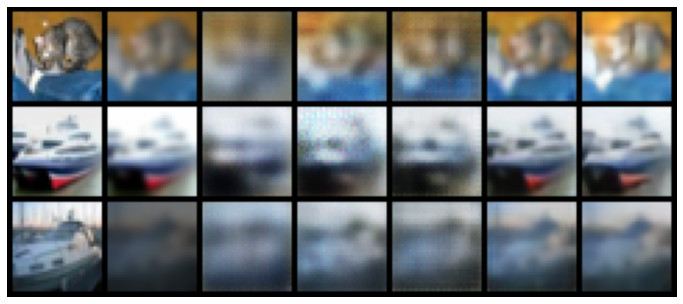

In [3]:
from plot import plot_results
from models import UNET, small_ae, large_ae, cnn
from pl_bolts.models.autoencoders import AE

model_paths = ['model_runs/small_ae2_mse_1', 'model_runs/large_ae2_mse_1', 'model_runs/cnn2_MSE_1', 'model_runs/small_unet2_MSE_1', 'model_runs/resnet2_mse_1']
model_list = [small_ae(3 ,128, latent_dim=512), large_ae(3, 128, latent_dim = 512), cnn(), UNET(features=[16, 32, 64, 128]), AE(input_height=32)]
model_names = ['CNN/FNN Small', 'CNN/FNN Large', 'CNN', 'UNET', 'Resnet18']

plot_results(data_loader = test_loader, model_list = model_list, model_paths = model_paths, model_names= model_names, normalize= True, pixel_range=(-1,1))

## 2 Effect of skip connections

### 2.1 Initialisation and visualising images

#### 2.1.1 Initialisation

##### Cats and Dogs subset of Imagenet dataset

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from pl_bolts.models.autoencoders import AE

from datasets import TransformedDataset

import torch.utils.data as data
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

# SSIM
from piqa import SSIM

from datasets import CatsAndDogs
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

# set the device to train on GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


torch.manual_seed(1)

dataset = ImageFolder('c:\\Users\\sdam9\\Documents\\dl_pro\\dogs-vs-cats\\train\\')

train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.1, random_state=9)
train_data, val_data = data.random_split(train_data, [18000, 4500])

### TRANSFORMS ###
# resize and add noise
input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.8,2))
])

valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, contrast = 0.3, saturation= 0.3),
    transforms.GaussianBlur(kernel_size=9, sigma=(0.8,2))
])

train_data = CatsAndDogs(dataset = train_data, transform = train_transform, input_transform = input_transform)
val_data = CatsAndDogs(dataset = val_data, transform = valid_transform, input_transform = input_transform)
test_data = CatsAndDogs(dataset = test_data, transform = valid_transform, input_transform = input_transform)

# set batch size and define the data loaders
batch_size = 100
test_size = 1

# define data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=2)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=False, drop_last=False, num_workers=2)

Device: cuda


#### 2.1.2 Visualising dataset

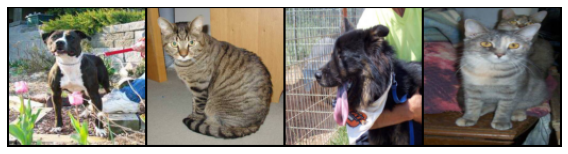

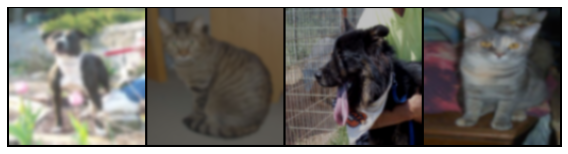

In [2]:
# function to show images
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.tight_layout()
    
# get some random training images
dataiter = iter(train_loader)
x_tran, y, x_in = dataiter.next()

# show images
n_images = 4
imshow(torchvision.utils.make_grid(x_in[:n_images], nrow= 4, normalize=True))
imshow(torchvision.utils.make_grid(x_tran[:n_images], nrow= 4, normalize=True))

### 2.2 Training Models

In [ ]:
import torch.optim as optimizer
from models import UNET, small_ae, large_ae, cnn, UNET_noskip, resnet18_ae

# hyper parameters
lr= 1e-4
w_decay = 1e-6
latent_dim = 512 # latent dimension

# model
#model = UNET(features=[16, 32, 64, 128])
model = UNET_noskip(features=[16, 32, 64, 128])

optim = optimizer.Adam(model.parameters(), lr=lr, weight_decay=w_decay)
scheduler = optimizer.lr_scheduler.ExponentialLR(optim, gamma = 0.90, last_epoch=- 1, verbose=True)

#ssim_fn = SSIM().to(device)
mse_fn = nn.MSELoss()

model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

All models were trained using the below training loop.

In [ ]:
from training import train, test
from tqdm import tqdm
import pickle 


num_epochs = 30
loss_dict={'train_loss':[],'val_loss':[]}


for epoch in range(num_epochs):

    train_loss=train(
        model = model,
        device=device, 
        dataloader=train_loader, 
        loss_1 = mse_fn, 
        optimizer=optim)
    
    val_loss = test(
        model = model, 
        device=device, 
        dataloader=valid_loader, 
        loss_1 = mse_fn,
        plot= True)

    #wandb.log({
     #   'training loss': train_loss,
      #  'test loss': val_loss})

    loss_dict['train_loss'].append(train_loss)
    loss_dict['val_loss'].append(val_loss)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

print("Finsished training")

PATH = "final_runs/unet_noskip_mse.pth"
torch.save(model.state_dict(), PATH)

# SAVE
with open("unet_noskip_mse.pkl", "wb") as pkl_handle:
	pickle.dump(loss_dict, pkl_handle)

### 2.3 Testing models: obtain test error and image reconstructions on test set

All model can now be evaluated on the test set.

In [2]:
from tqdm import tqdm
from models import UNET, UNET_noskip
from piqa import SSIM

MSE = torch.nn.MSELoss(reduction='mean')
ssim = SSIM()

model_paths = ['./unet_mse', './unet_noskip_mse', './unet_ssim', './unet_noskip_ssim']
model_list = [UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128])]
model_names = ['UNET_MSE' , 'UNET_MSE_noskip', 'UNET_SSIM', 'UNET_SSIM_noskip']


for (model, name, path) in zip(model_list, model_names, model_paths):
    print(name)

    # load model
    PATH = 'final_runs/'+path+'.pth'
    model = model
    model.load_state_dict(torch.load(PATH))

    MSEs = []
    SSIMs = []
    for j, (noisy, _, input) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # evaluate the model on the test set
        model.eval()
        with torch.no_grad():
            recon = model(noisy)
        MSEs.append(MSE(recon, input).numpy())
        SSIMs.append(ssim(recon, input).numpy())

    print(f'MSE: {np.mean(MSEs)}')
    print(f'MSSIM: {np.mean(SSIMs)}')

UNET_MSE


100%|██████████| 2500/2500 [00:57<00:00, 43.52it/s]


MSE: 0.004664257634431124
MSSIM: 0.8498765826225281
UNET_MSE_noskip


100%|██████████| 2500/2500 [01:02<00:00, 39.85it/s]


MSE: 0.008668642491102219
MSSIM: 0.6261969208717346
UNET_SSIM


100%|██████████| 2500/2500 [00:57<00:00, 43.19it/s]


MSE: 0.005068655591458082
MSSIM: 0.9105059504508972
UNET_SSIM_noskip


100%|██████████| 2500/2500 [01:02<00:00, 40.01it/s]

MSE: 0.013258453458547592
MSSIM: 0.7309898734092712


Image quality for each model can now be investigated.

SSIM: 0.8513468503952026
MSE: 0.008763371966779232


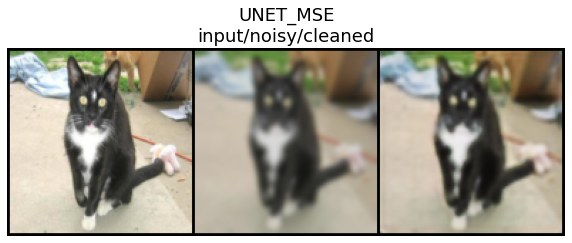

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM: 0.6692844033241272
MSE: 0.009561102837324142


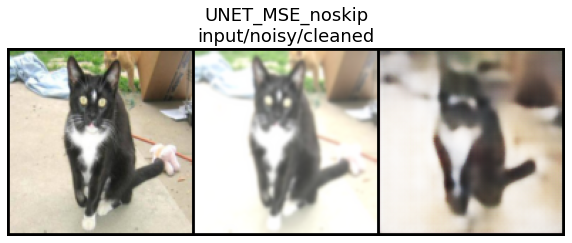

SSIM: 0.8744153380393982
MSE: 0.0065317354165017605


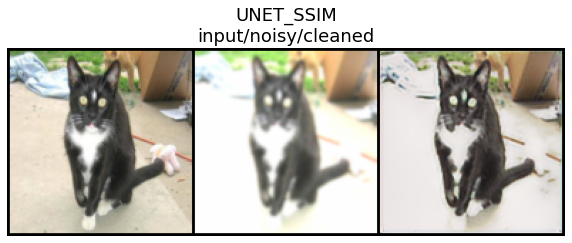

SSIM: 0.7551466226577759
MSE: 0.034033771604299545


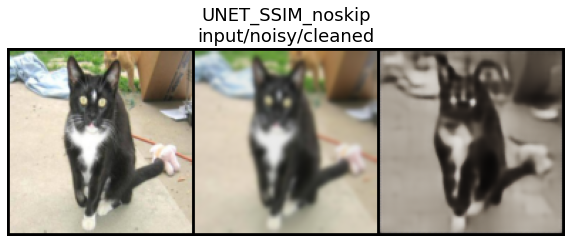

In [3]:
from tqdm import tqdm
from models import UNET, UNET_noskip
from piqa import SSIM
from plot import plot_recon

MSE = torch.nn.MSELoss(reduction='mean')
ssim = SSIM()

model_paths = ['./unet_mse', './unet_noskip_mse', './unet_ssim', './unet_noskip_ssim']
model_list = [UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128])]
model_names = ['UNET_MSE' , 'UNET_MSE_noskip', 'UNET_SSIM', 'UNET_SSIM_noskip']


for (model, name, path) in zip(model_list, model_names, model_paths):
    PATH = 'final_runs/'+path+'.pth'
    model.load_state_dict(torch.load(PATH))
    plot_recon(model, test_loader, title = name, normalize=False, pixel_range=(0,1))

The effect of the skip-connection architecture on image reconstruction quality can now be plotted.

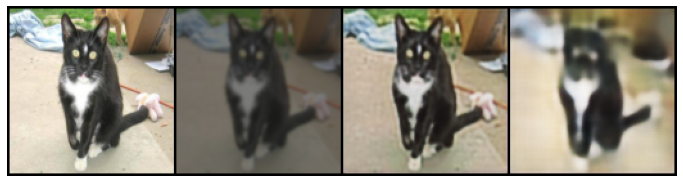

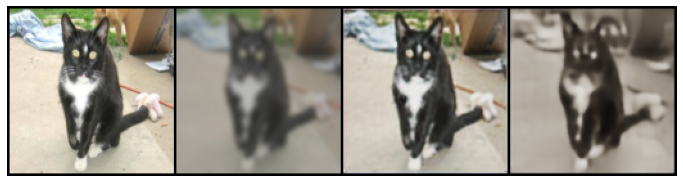

In [2]:
from plot import plot_results
from models import UNET, UNET_noskip

model_paths = ['final_runs/unet_mse', 'final_runs/unet_noskip_mse']
model_list = [UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128])]
model_names = ['UNET_MSE' , 'UNET_MSE_noskip']
plot_results(data_loader = test_loader, model_list = model_list, model_paths = model_paths, model_names= model_names, normalize= False, pixel_range=(0,1))


model_paths = ['final_runs/unet_ssim', 'final_runs/unet_noskip_ssim']
model_list = [UNET(features=[16, 32, 64, 128]), UNET_noskip(features=[16, 32, 64, 128])]
model_names = ['UNET_SSIM', 'UNET_SSIM_noskip']
plot_results(data_loader = test_loader, model_list = model_list, model_paths = model_paths, model_names= model_names, normalize= False, pixel_range=(0,1))


Learnig is much slower when the skip-connections are removed.

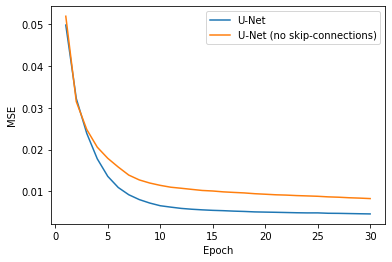

In [3]:
import pickle
import matplotlib.pyplot as plt

# LOAD
with open("unet_mse.pkl", "rb") as pkl_handle:
	unet_mse = pickle.load(pkl_handle)

with open("unet_noskip_mse.pkl", "rb") as pkl_handle:
	unet_noskip_mse = pickle.load(pkl_handle)


x = np.arange(1,31, 1)
plt.plot(x, unet_mse['train_loss'], label = 'U-Net')
plt.plot(x, unet_noskip_mse['train_loss'], label = 'U-Net (no skip-connections)')
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

## 3. Choice of loss function

To investigate the effect the chosen loss function has on image quality of reconstructed images the U-Net model is trained on all different losses: MSE, SSIM, L1 and BCE.

In [ ]:
from training import train, test
import pickle
import torch.optim as optimizer
from models import UNET

# hyper parameters
lr= 1e-4
w_decay = 1e-6
latent_dim = 512 # latent dimension

# model
model = UNET(features=[16, 32, 64, 128])

optim = optimizer.Adam(model.parameters(), lr=lr, weight_decay=w_decay)
scheduler = optimizer.lr_scheduler.ExponentialLR(optim, gamma = 0.90, last_epoch=- 1, verbose=True)

ssim_loss = SSIM().to(device)
#mse_loss = nn.MSELoss()
L1_loss = nn.L1Loss()
#bce_loss = nn.BCELoss()

model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

num_epochs = 30
loss_dict={'train_loss':[],'val_loss':[]}


for epoch in range(num_epochs):

    train_loss=train(
        model = model,
        device=device, 
        dataloader=train_loader, 
        loss_1 = L1_loss,
        loss_2 = ssim_loss, 
        optimizer=optim)
    
    val_loss = test(
        model = model, 
        device=device, 
        dataloader = valid_loader,
        loss_1 = L1_loss,
        loss_2 = ssim_loss,
        plot= True)

    loss_dict['train_loss'].append(train_loss)
    loss_dict['val_loss'].append(val_loss)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

print("Finsished training")

PATH = "final_runs/unet_L1_SSIM.pth"
torch.save(model.state_dict(), PATH)

# SAVE
with open("unet_L1_SSIM.pkl", "wb") as pkl_handle:
	pickle.dump(loss_dict, pkl_handle)


The resulting image reconstructions can now be visualised next to the clean and noise images.

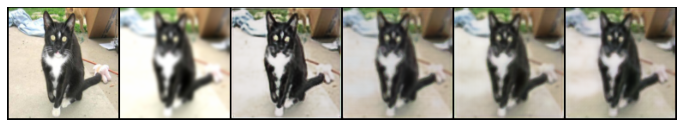

In [2]:
from models import UNET
from plot import plot_results
model_paths = ['final_runs/unet_ssim', 'final_runs/unet_mse', 'final_runs/unet_L1', 'final_runs/unet_BCE',]
model_list = [UNET(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128])]
model_names = ['UNET_SSIM', 'UNET_MSE', 'UNET_L1Loss', 'UNET_BCE']
plot_results(data_loader = test_loader, model_list = model_list, model_paths = model_paths, model_names= model_names, normalize= False, pixel_range=(0,1))

The two best loss functions from above are combined into one loss function (SSIM + L1) and compared to the best loss (SSIM)

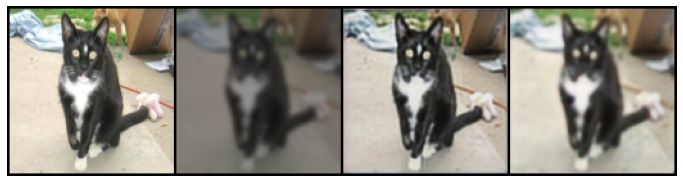

In [2]:
from models import UNET
from plot import plot_results
model_paths = ['final_runs/unet_ssim', 'final_runs/unet_L1']
model_list = [UNET(features=[16, 32, 64, 128]), UNET(features=[16, 32, 64, 128])]
model_names = ['UNET_SSIM',  'UNET_L1_SSIM']
plot_results(data_loader = test_loader, model_list = model_list, model_paths = model_paths, model_names= model_names, normalize= False, pixel_range=(0,1))